In [1]:
%load_ext autoreload
%autoreload 2

#

import numpy as np
import netCDF4 as ncdf
import matplotlib as mlab
import matplotlib.pyplot as plt
import xarray as xr
import glob as glob
import os as os
import sys as sys
from filter.RaymondFilters import RaymondFilter6, RaymondFilter10


Text(0.5, 0.98, 'One-Dimensional High-Pass Filtering using Raymond-6th order Filter')

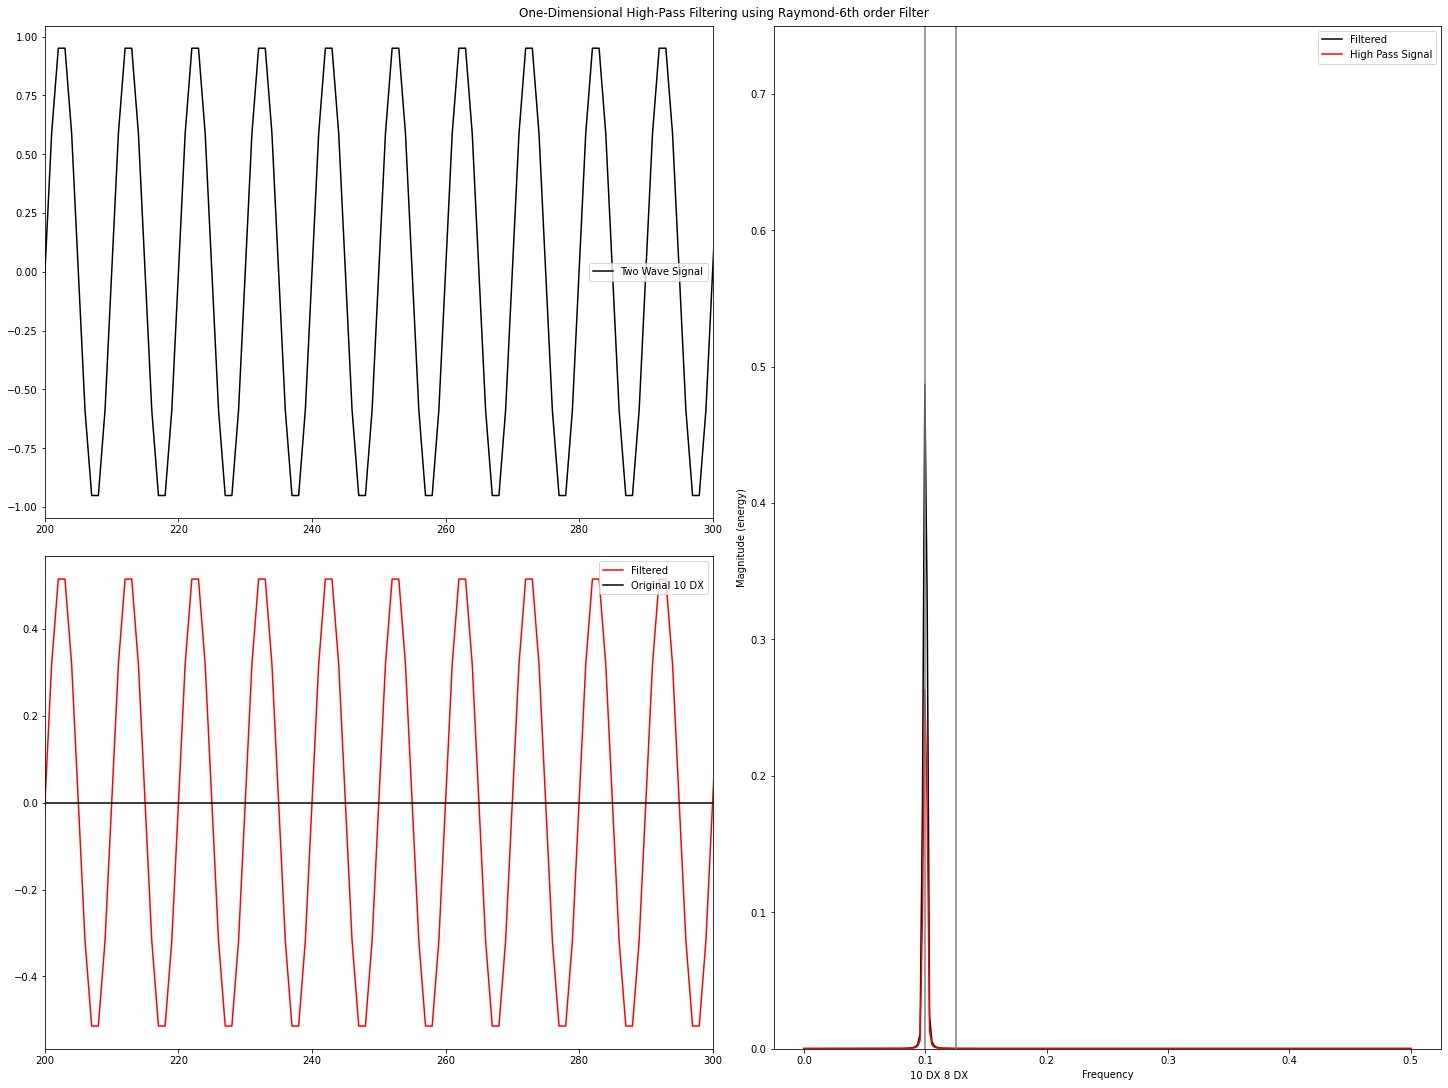

In [4]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

wave1 = [0.0,8.0]
wave2 = [1.0,10.0]
x     = np.arange(512)
eps   = 1000.

field1 = wave1[0]*np.sin(2.0*np.pi*x/wave1[1])
field2 = wave2[0]*np.sin(2.0*np.pi*x/wave2[1])

field = field1 + field2

ffield = field - RaymondFilter6(field.copy(), eps)

# Plot answers

fig = plt.figure(constrained_layout=True,figsize=(20,15))

gs = gridspec.GridSpec(2, 2, figure=fig)

ax1 = fig.add_subplot(gs[0, :-1])
ax2 = fig.add_subplot(gs[1, :-1])

ax1.plot(x, field, color='k', label='Two Wave Signal')
ax1.legend(['Two Wave Signal'])
ax1.set_xlim(200,300)
# ax1.set_ylim(-2.0,2.0)
ax2.plot(x, ffield, color='r', label='Filtered')
ax2.plot(x, field1, color='k', label='High Pass')
ax2.set_xlim(200,300)
ax2.legend(['Filtered', 'Original 10 DX'])

ax3 = fig.add_subplot(gs[:, 1])

line1 = ax3.magnitude_spectrum(field, Fs=1.0, color='k', label='Two Wave Signal')
line2 = ax3.magnitude_spectrum(ffield, Fs=1.0, color='r', label='High Pass Signal')
ax3.legend(['Filtered', 'High Pass Signal'])
ax3.set_ylim(.0,0.75)
ax3.plot([1.0/wave1[1],1.0/wave1[1]], [0.0, 1.0], color='grey')
ax3.plot([1.0/wave2[1],1.0/wave2[1]], [0.0, 1.0], color='grey')
ax3.text(1.0/wave2[1], -0.02, "%d DX" % (int(wave2[1])), va="center", ha="center")
ax3.text(1.0/wave1[1], -0.02, "%d DX" % (int(wave1[1])), va="center", ha="center")

plt.suptitle("One-Dimensional High-Pass Filtering using Raymond-6th order Filter")


Text(0.5, 0.98, 'One-Dimensional High-Pass Filtering using Raymond-10th order Filter')

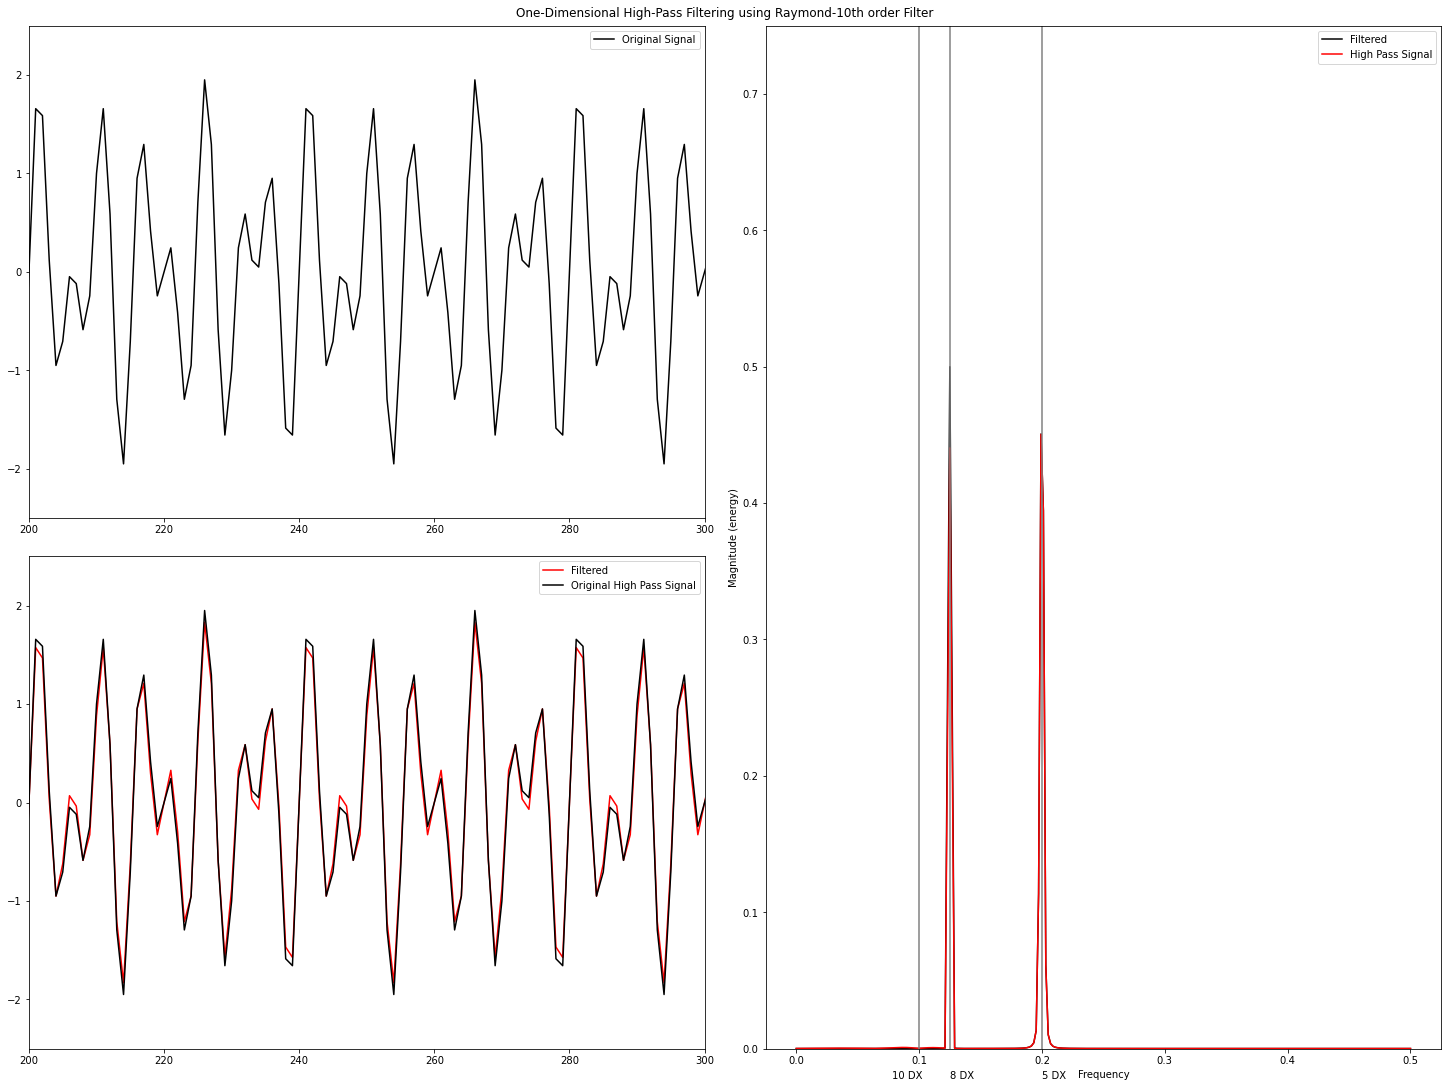

In [10]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

wave0 = [1.0,5.0]
wave1 = [1.0,8.0]
wave2 = [.0,10.0]
x     = np.arange(512)
eps   = 50000.

field1 = wave1[0]*np.sin(2.0*np.pi*x/wave1[1]) + wave0[0]*np.sin(2.0*np.pi*x/wave0[1])
field2 = wave2[0]*np.sin(2.0*np.pi*x/wave2[1])

field = field1 + field2

ffield = field - RaymondFilter10(field.copy(), eps)

fig = plt.figure(constrained_layout=True,figsize=(20,15))

gs = gridspec.GridSpec(2, 2, figure=fig)

ax1 = fig.add_subplot(gs[0, :-1])
ax2 = fig.add_subplot(gs[1, :-1])

ax1.plot(x, field, color='k', label='Original Signal')
ax1.legend(['Original Signal'])
ax1.set_xlim(200,300)
ax1.set_ylim(-2.5,2.5)
ax2.plot(x, ffield, color='r', label='Filtered Signal')
ax2.plot(x, field1, color='k', label='High Pass')
ax2.set_xlim(200,300)
ax2.legend(['Filtered', 'Original High Pass Signal'])
ax2.set_ylim(-2.5,2.5)

ax3 = fig.add_subplot(gs[:, 1])

line1 = ax3.magnitude_spectrum(field, Fs=1.0, color='k', label='Two Wave Signal')
line2 = ax3.magnitude_spectrum(ffield, Fs=1.0, color='r', label='High Pass Signal')
ax3.legend(['Filtered', 'High Pass Signal'])
ax3.set_ylim(.0,0.75)
ax3.plot([1.0/wave1[1],1.0/wave1[1]], [0.0, 1.0], color='grey')
ax3.plot([1.0/wave2[1],1.0/wave2[1]], [0.0, 1.0], color='grey')
ax3.plot([1.0/wave0[1],1.0/wave0[1]], [0.0, 1.0], color='grey')
ax3.text(1.0/wave2[1]-0.01, -0.02, "%d DX" % (int(wave2[1])), va="center", ha="center")
ax3.text(1.0/wave1[1]+0.01, -0.02, "%d DX" % (int(wave1[1])), va="center", ha="center")
ax3.text(1.0/wave0[1]+0.01, -0.02, "%d DX" % (int(wave0[1])), va="center", ha="center")

plt.suptitle("One-Dimensional High-Pass Filtering using Raymond-10th order Filter")